In [1]:
import time
import psycopg2
from datetime import datetime
from config import config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

## Data Preparation
1. Load the data into dataframe
2. Drop Time Column
3. Add time with date (5min interval)
4. Perform resampling from 5 min to 30 min to reduce the rows
5. Plotting df and correlations with data lags

Refrence- https://machinelearningmastery.com/resample-interpolate-time-series-data-python/

In [2]:
#For one Plant (PlantId=12245) having solarlogid=670 and subdomain=home7
df= pd.read_csv(r"C:\Users\hemip\Downloads\DataPrep\new_yield.csv", header=0, sep=';', index_col='date', squeeze=True, parse_dates=True)
df

,time,yield
date,,
2019-09-12,00:00:00,0
2019-09-12,00:05:00,0
2019-09-12,00:10:00,0
2019-09-12,00:15:00,0
2019-09-12,00:20:00,0
...,...,...
2020-08-12,13:00:00,2060
2020-08-12,13:05:00,2010
2020-08-12,13:10:00,2100


In [3]:
df.index

DatetimeIndex(['2019-09-12', '2019-09-12', '2019-09-12', '2019-09-12',
               '2019-09-12', '2019-09-12', '2019-09-12', '2019-09-12',
               '2019-09-12', '2019-09-12',
               ...
               '2020-08-12', '2020-08-12', '2020-08-12', '2020-08-12',
               '2020-08-12', '2020-08-12', '2020-08-12', '2020-08-12',
               '2020-08-12', '2020-08-12'],
              dtype='datetime64[ns]', name='date', length=104979, freq=None)

In [4]:
df.drop(columns=['time'])

,yield
date,
2019-09-12,0
2019-09-12,0
2019-09-12,0
2019-09-12,0
2019-09-12,0
...,...
2020-08-12,2060
2020-08-12,2010
2020-08-12,2100


In [5]:
df.index= pd.date_range('2019-09-12', periods=104979, freq='5T')

In [6]:
df.index

DatetimeIndex(['2019-09-12 00:00:00', '2019-09-12 00:05:00',
               '2019-09-12 00:10:00', '2019-09-12 00:15:00',
               '2019-09-12 00:20:00', '2019-09-12 00:25:00',
               '2019-09-12 00:30:00', '2019-09-12 00:35:00',
               '2019-09-12 00:40:00', '2019-09-12 00:45:00',
               ...
               '2020-09-10 11:25:00', '2020-09-10 11:30:00',
               '2020-09-10 11:35:00', '2020-09-10 11:40:00',
               '2020-09-10 11:45:00', '2020-09-10 11:50:00',
               '2020-09-10 11:55:00', '2020-09-10 12:00:00',
               '2020-09-10 12:05:00', '2020-09-10 12:10:00'],
              dtype='datetime64[ns]', length=104979, freq='5T')

In [7]:
 df= df.resample('D').mean()

In [10]:
print(df['yield'])

2019-09-12    360.930556
2019-09-13    325.114583
2019-09-14     69.371528
2019-09-15    217.208333
2019-09-16    159.173611
                 ...    
2020-09-06     54.635417
2020-09-07     73.458333
2020-09-08     27.666667
2020-09-09    263.774306
2020-09-10    779.102041
Freq: D, Name: yield, Length: 365, dtype: float64


<AxesSubplot:>

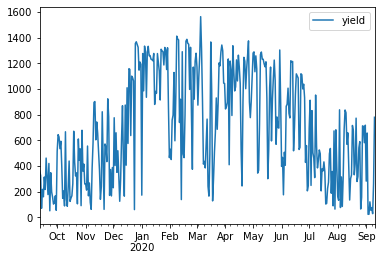

In [8]:
df.plot()

In [11]:
df.index.name= 'date'

In [12]:
df

,yield
date,
2019-09-12,360.930556
2019-09-13,325.114583
2019-09-14,69.371528
2019-09-15,217.208333
2019-09-16,159.173611
...,...
2020-09-06,54.635417
2020-09-07,73.458333
2020-09-08,27.666667


reference: https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

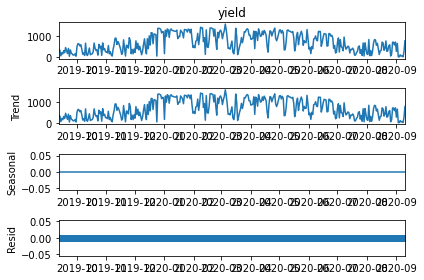

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
result = seasonal_decompose(df['yield'], model='additive', extrapolate_trend='freq', period=1)
#print(result.trend)
# print(result.seasonal)
# print(result.resid)
# print(result.observed)
result.plot()
pyplot.show()

Refrence: https://machinelearningmastery.com/time-series-trends-in-python/

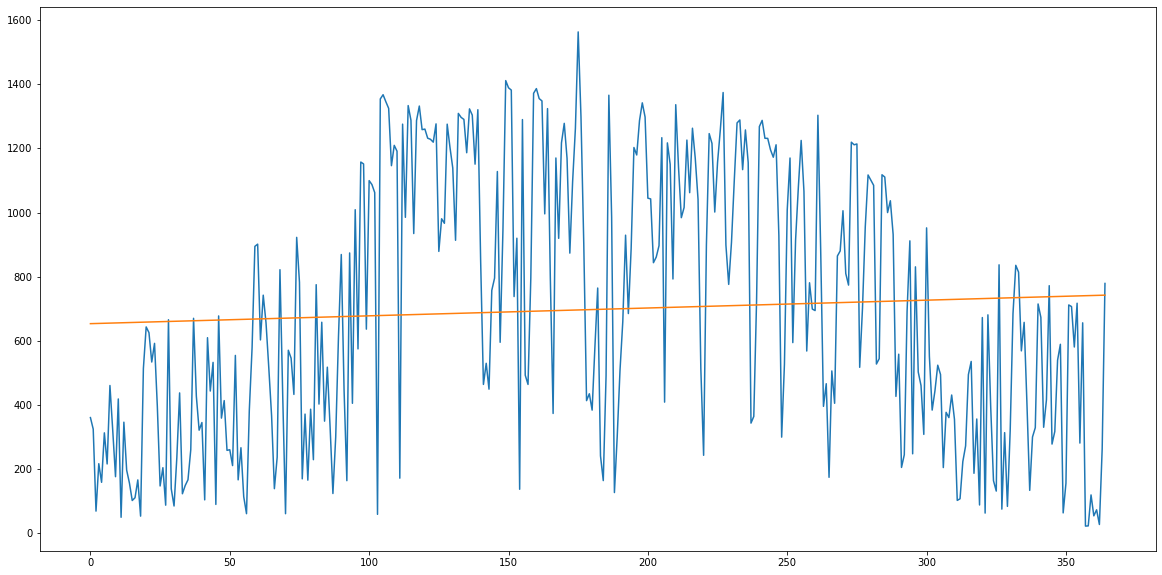

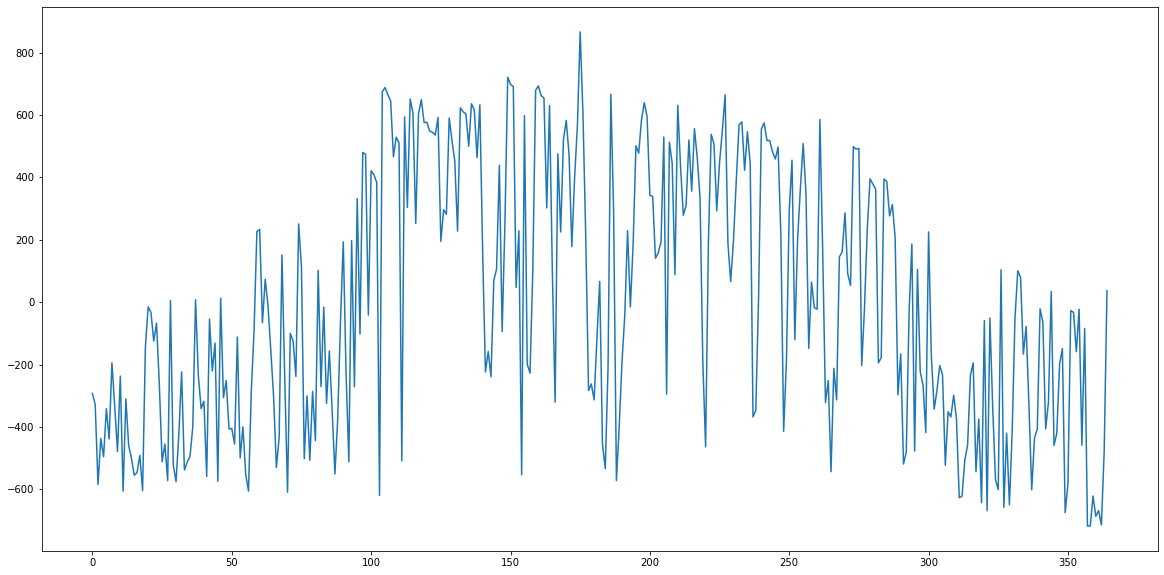

In [21]:
from pandas import datetime
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
import numpy
X = [i for i in range(0, len(df))]
X = numpy.reshape(X, (len(X), 1))
y = df.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
# plot trend
pyplot.plot(y)
pyplot.plot(trend)
pyplot.show()
# detrend
detrended = [y[i]-trend[i] for i in range(0, len(df))]
# plot detrended
pyplot.plot(detrended)
pyplot.show()

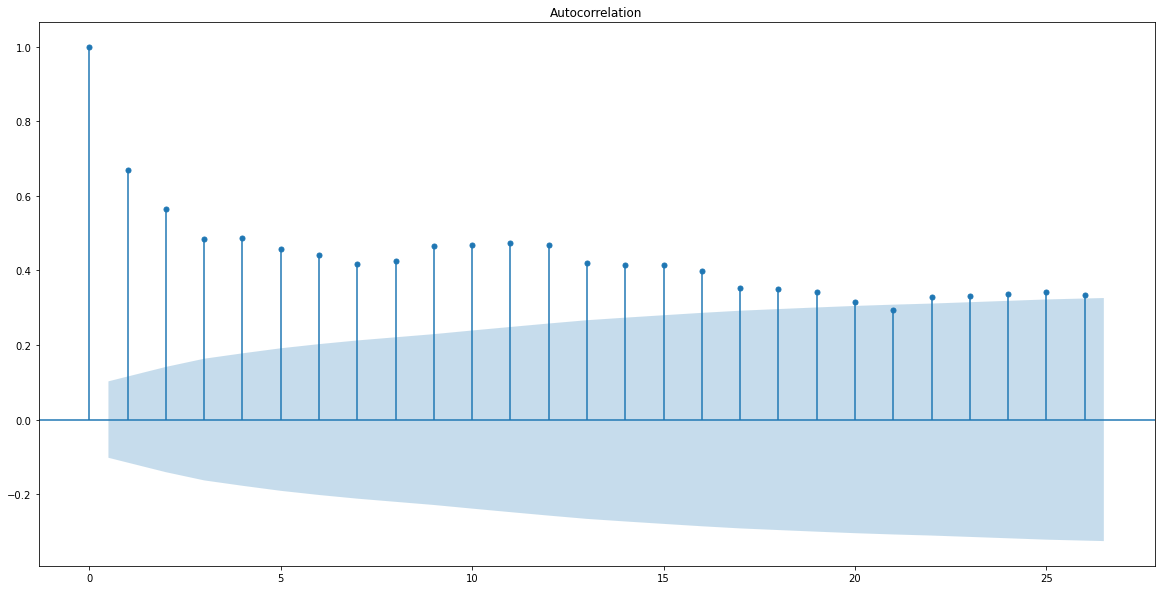

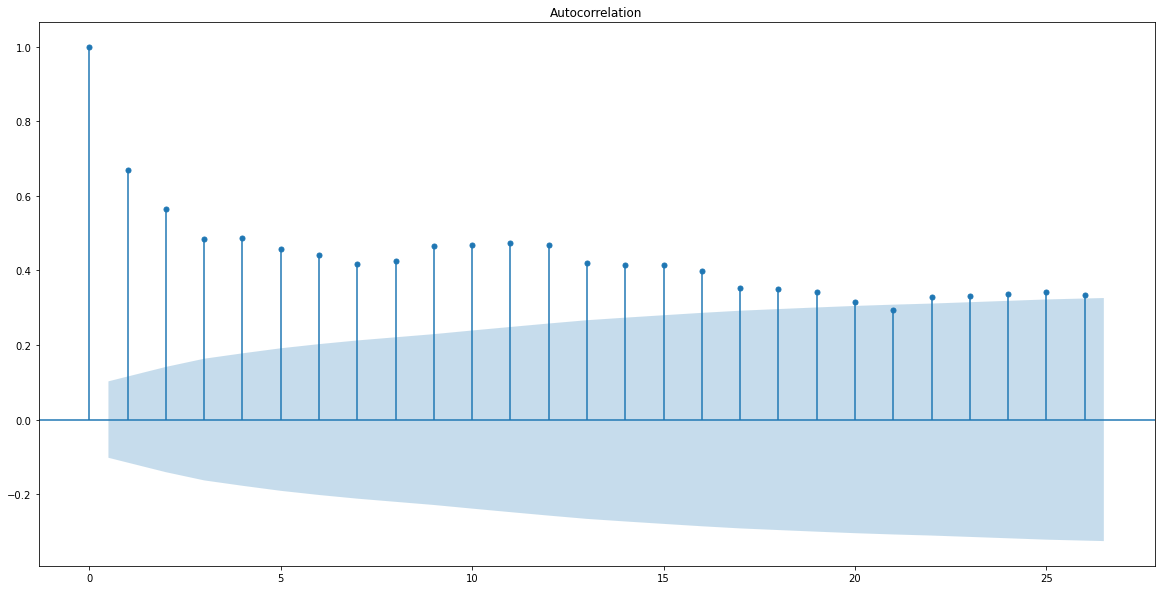

In [23]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df)


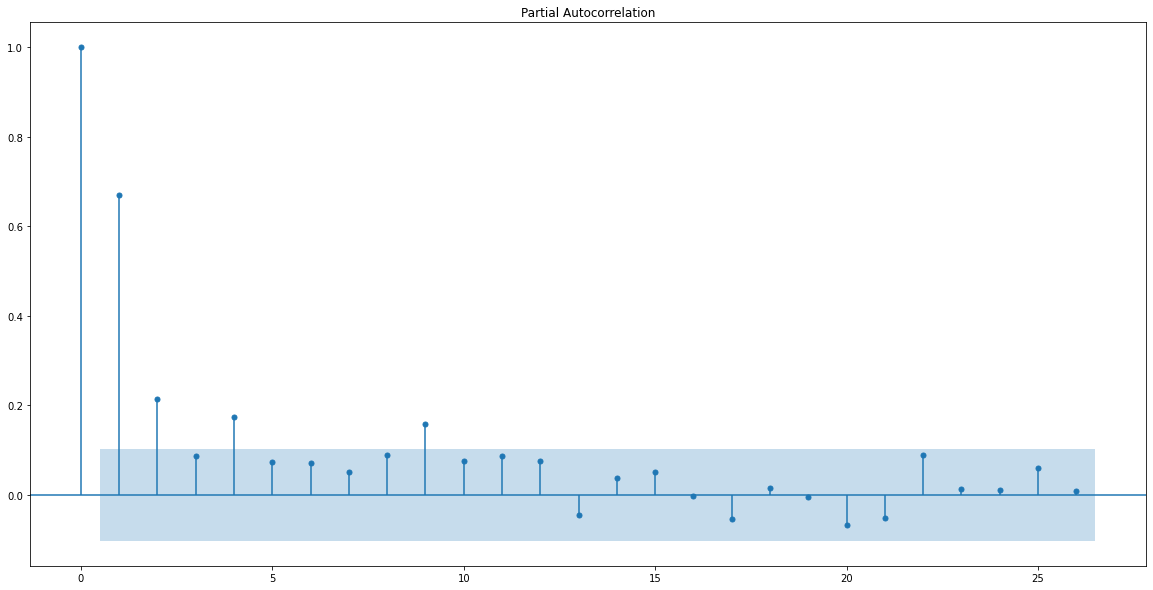

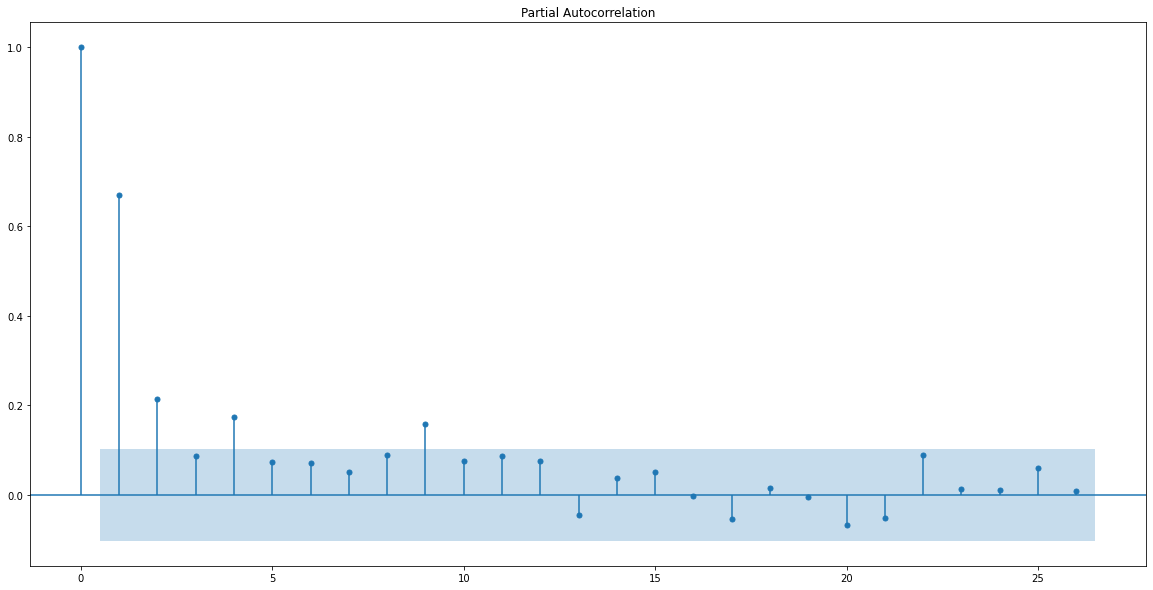

In [24]:
plot_pacf(df)

## MODEL BUILDING
References:
pdarima- https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
forecast- https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/#:~:text=A%20popular%20and%20widely%20used,structures%20in%20time%20series%20data.

In [25]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima_model import ARMA,ARIMA, ARMAResults, ARIMAResults

In [26]:
#using pmdarima to determine the best parameters (plag, order, qlag) 
from pmdarima import auto_arima 
auto_arima(df['yield'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2577.775
Date:                Mon, 21 Dec 2020   AIC                           5161.550
Time:                        17:06:26   BIC                           5173.242
Sample:                             0   HQIC                          5166.197
                                - 365                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3339      0.050      6.662      0.000       0.236       0.432
ma.L1         -0.9004      0.024    -37.367      0.000      -0.948      -0.853
sigma2      8.271e+04   6246.895     13.240      0.000    7.05e+04     9.5e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 4.27
Prob(Q):                              0.85   Prob(JB):                         0.12
Heteroskedasticity (H):               0.95   Skew:                            -0.24
Prob(H) (two-sided):                  0.79   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
# split into train and test sets
X = df.values
size = int(len(X) * 0.86)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = SARIMAX(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))


predicted=292.736476, expected=223.767361
predicted=325.444105, expected=272.781250
predicted=336.606669, expected=494.913194
predicted=432.291511, expected=535.947917
predicted=458.313038, expected=187.260417
predicted=306.659855, expected=356.520833
predicted=371.042940, expected=88.500000
predicted=247.169143, expected=672.822917
predicted=495.128994, expected=63.222222
predicted=240.177481, expected=681.267361
predicted=494.680587, expected=394.875000
predicted=388.392825, expected=164.149306
predicted=287.932981, expected=131.840278
predicted=260.196589, expected=837.211806
predicted=554.691503, expected=75.586806
predicted=255.705076, expected=314.013889
predicted=337.841426, expected=84.128472
predicted=237.188455, expected=322.065972
predicted=321.886929, expected=685.277778
predicted=476.958197, expected=835.628472
predicted=565.649002, expected=814.416667
predicted=586.519695, expected=568.920139
predicted=503.892146, expected=657.805556
predicted=549.552100, expected=405.604

Test RMSE: 267.884


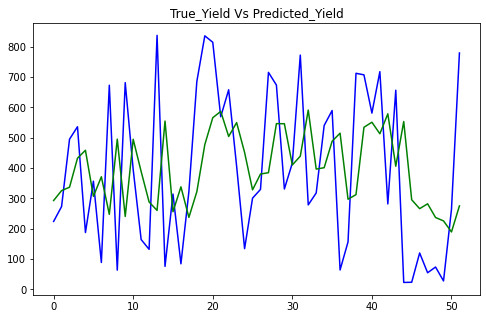

In [31]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test, color='blue')
plt.plot(predictions, color='green')
#plt.figure()
plt.title("True_Yield Vs Predicted_Yield")
plt.rcParams["figure.figsize"] = [8,5]